# Homework 4
- Student: Aleksandra Kocot
 - [Git Hub page with the Homework Week4 questions](https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/cohorts/2023/04-evaluation/homework.md)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv

--2023-09-23 16:48:28--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71,53K  --.-KB/s    in 0,04s   

2023-09-23 16:48:29 (1,58 MB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from tqdm.auto import tqdm

##### The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column: card).

## Preparation
Create the target variable by mapping yes to 1 and no to 0.<br>
Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1.

In [2]:
df_raw = pd.read_csv("AER_credit_card_data.csv")

In [3]:
df_raw

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


#### Target variable

In [4]:
df_raw["target"] = (df_raw["card"] == "yes").astype(int)

In [5]:
df_raw

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active,target
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12,1
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13,1
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5,1
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7,1
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19,1
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5,0
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2,1
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7,1


#### Train, test, validation set split

In [6]:
df_full, df_test = train_test_split(df_raw, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

del df_train["target"] 
del df_val["target"]
del df_test["target"] 

## Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.<br>

Let's do that<br>

For each numerical variable, use it as score and compute AUC with the card variable.<br>
Use the training dataset for that.<br>
If your AUC is < 0.5, invert this variable by putting "-" in front<br>

(e.g. -df_train['expenditure'])<br>

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. <br>
You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.<br>
<br>
Which numerical variable (among the following 4) has the highest AUC?
- reports
- dependents
- active
- share


In [7]:
df_train

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,no,3,40.50000,4.0128,0.000299,0.00000,no,no,1,12,1,17
1,no,1,32.33333,6.0000,0.000200,0.00000,yes,no,4,18,1,4
2,yes,1,29.16667,2.2000,0.038205,69.79333,no,no,0,49,1,7
3,yes,1,54.66667,7.2900,0.106536,647.20670,yes,no,2,78,1,9
4,yes,0,25.00000,3.3984,0.000353,0.00000,yes,no,2,29,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
786,yes,0,53.00000,2.4500,0.017718,35.67500,yes,no,0,3,1,11
787,no,2,30.58333,2.5000,0.000480,0.00000,no,no,0,12,1,18
788,yes,0,24.75000,1.8750,0.080708,126.02250,no,no,1,14,0,1
789,yes,1,56.91667,3.4838,0.062895,182.09580,yes,no,0,540,1,7


In [11]:
np.correlate(y_train, df_train[c])[0]

81

In [13]:
aucs = {}
numeric_cols = [c for c in df_train.columns if c not in ["card", "owner", "selfemp"]]
for c in numeric_cols:
    feature_auc = roc_auc_score(y_train, df_train[c])
    feature_corr = np.corrcoef(y_train, df_train[c])
    if feature_auc < 0.5:
            feature_auc = roc_auc_score(y_train, -df_train[c])
    aucs[c] = [feature_auc, abs(feature_corr[0][1])]
    

In [14]:
results = pd.DataFrame(aucs).T
results.columns = ["AUC","COR_abs"]

In [15]:
results.sort_values(by="AUC", ascending=False).style.background_gradient(axis=0)  

,AUC,COR_abs
expenditure,0.991042,0.391337
share,0.989184,0.406993
reports,0.716663,0.448771
active,0.604317,0.107173
income,0.590805,0.102310
majorcards,0.534386,0.074889
dependents,0.532776,0.056133
months,0.529422,0.033637
age,0.524002,0.033578


Correlation shows linear relation while AUC detect also non-linear one so it may be useful for non-linear models.
- But logistic regression is linear underneath, so here it may be misleading (?)

#### ROC AUC

In [16]:
roc_auc_score([0,0,0,0,1,1,1,1], [0,0,0,0,1,1,1,1])

1.0

In [17]:
roc_auc_score([0,0,0,0,1,1,1,1], [0,1,0,1,0,1,0,1])

0.5

In [18]:
roc_auc_score([0,0,0,0,1,1,1,1], [10,20,30,40,50,60,70,80])

1.0

In [19]:
roc_auc_score([0,0,0,0,1,1,1,1], [10,20,30,40,45,46,47,48])

1.0

#### Correlation

In [20]:
np.corrcoef([0,0,0,0,1,1,1,1], [10,20,30,40,50,60,70,80])[0][1]

0.8728715609439693

In [21]:
np.corrcoef([0,0,0,0,1,1,1,1], [10,20,30,40,45,46,47,48])[0][1]

0.804195017233548

#### Training the model
From now on, use these columns only: <br>

["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]<br>
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:<br>

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

## Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)
- 0.615
- 0.515
- 0.715
- 0.995

In [22]:
cols  =["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [23]:
train_dict = df_train[cols].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[cols].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:,1]

accuracy = roc_auc_score(y_val, y_pred)
np.round(accuracy,3)

0.995

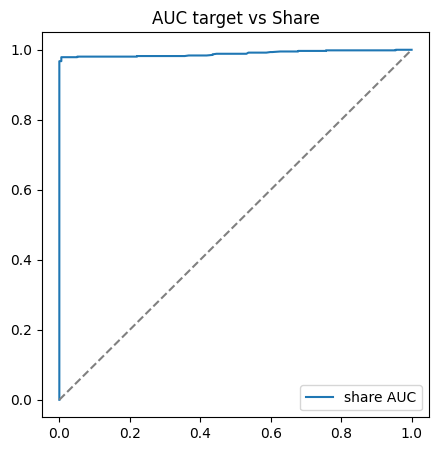

In [24]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_train, df_train.share)
plt.plot(fpr, tpr, label='share AUC')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.title("AUC target vs Share")
plt.legend()
plt.show()

## Question 3
Now let's compute precision and recall for our model.<br>

Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01<br>
For each threshold, compute precision and recall<br>
Plot them<br>
At which threshold precision and recall curves intersect?
- 0.1
- 0.3
- 0.6
- 0.8

In [25]:
thrs = np.linspace(0,0.99,100)
thrs

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [27]:
precision_recall = {}
for t in thrs:
    precision = precision_score(y_val, y_pred>t)
    recall = recall_score(y_val, y_pred>t)
    precision_recall[t] = [precision, recall]

In [28]:
df_p_r = pd.DataFrame(precision_recall).T
df_p_r.columns = ["precision", "recall"]

<Figure size 600x600 with 0 Axes>

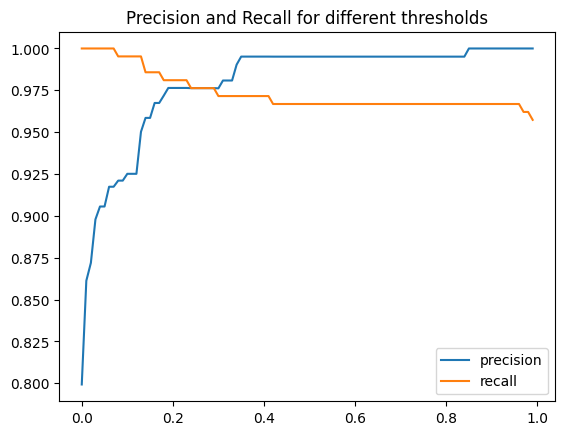

In [29]:
plt.figure(figsize=(6, 6));
df_p_r.plot();
plt.title("Precision and Recall for different thresholds");

In [30]:
df_p_r.loc[df_p_r.precision == df_p_r.recall]

,precision,recall
0.24,0.976303,0.976303
0.25,0.976303,0.976303
0.26,0.976303,0.976303
0.27,0.976303,0.976303
0.28,0.976303,0.976303
0.29,0.976303,0.976303


##### Answer: Precision and recall intersect for thresholds about 0.26 (0.24 - 0.29)

## Question 4
Precision and recall are conflicting - when one grows, the other goes down.<br> 
That's why they are often combined into the F1 score - a metrics that takes into account both<br>

This is the formula for computing <br>
F1 = 2 * P * R / ( P + R )
Where <br>
P is precision and<br> 
R is recall.<br>

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set<r>

At which threshold F1 is maximal?
- 0.1
- 0.4
- 0.6
- 0.7

In [31]:
df_p_r["f1_score"] = 2 * df_p_r.precision * df_p_r.recall * (df_p_r.precision + df_p_r.recall)

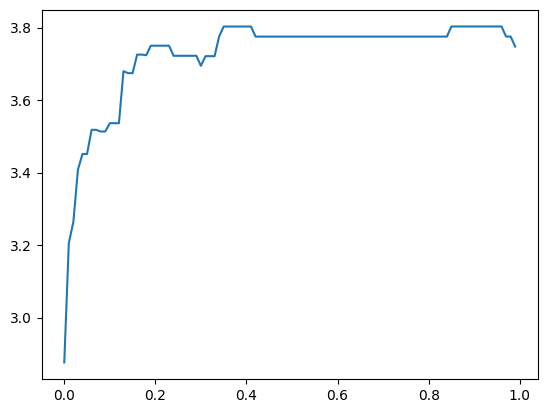

In [32]:
df_p_r.f1_score.plot();

In [33]:
df_p_r.sort_values(by=["f1_score"], ascending=False).head(20)

,precision,recall,f1_score
0.86,1.000000,0.966825,3.803149
0.92,1.000000,0.966825,3.803149
0.85,1.000000,0.966825,3.803149
0.87,1.000000,0.966825,3.803149
0.88,1.000000,0.966825,3.803149
0.89,1.000000,0.966825,3.803149
0.90,1.000000,0.966825,3.803149
0.91,1.000000,0.966825,3.803149
0.93,1.000000,0.966825,3.803149
0.94,1.000000,0.966825,3.803149


##### Answer: F1 score is the highest for threshold about 0.38 (0.34 - 0.41) and same value for about 0.9 (0.85 - 0.96) 

## Question 5
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:<br>

KFold(n_splits=5, shuffle=True, random_state=1)<br>
Iterate over different folds of df_full_train<br>
Split the data into train and validation<br>
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)<br>
Use AUC to evaluate the model on validation<br>
How large is standard devidation of the AUC scores across different folds?
- 0.003
- 0.014
- 0.09
- 0.24

In [34]:
def train(df_train, y_train, c=1.0):
    train_dict = df_train[cols].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dict)
    X_train = dv.transform(train_dict)
    
    model = LogisticRegression(solver="liblinear", C=c, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

def predict(df, dv, model):
    dicts = df[cols].to_dict(orient='records')
    X = dv.transform(dicts)
    return model.predict_proba(X)[:,1]

In [35]:
dv, model = train(df_train, y_train)
y_pred = predict(df_val, dv, model)

In [36]:
scores = []

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full):
    df_train = df_full.iloc[train_idx]
    df_val = df_full.iloc[val_idx]
    
    y_train = df_train.target
    y_val = df_val.target
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(f"{np.mean(scores):0.3f} +- {np.std(scores):0.3f}")

0.996 +- 0.003


## Question 6
Now let's use 5-Fold cross-validation to find the best parameter C<br>

Iterate over the following C values: [0.01, 0.1, 1, 10]<br>
Initialize KFold with the same parameters as previously<br>
Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)<r>
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)<br>
Which C leads to the best mean score?
- 0.01
- 0.1
- <b>1</b>
- 10

<br>If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [54]:
Cs = {}
n_splits=5
for c in tqdm([0.01, 0.1, 1, 10]):
    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    for train_idx, val_idx in kfold.split(df_full):
        df_train = df_full.iloc[train_idx]
        df_val = df_full.iloc[val_idx]
        
        y_train = df_train.target
        y_val = df_val.target
        
        dv, model = train(df_train, y_train, c)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    
        Cs[c] = [np.mean(scores), np.std(scores)]

  0%|          | 0/4 [00:00<?, ?it/s]

In [55]:
final_scores = pd.DataFrame(Cs).T
final_scores.columns = ["auc_avg", "auc_std"]

In [56]:
final_scores.sort_values(by="auc_avg", ascending=False).round(3)

,auc_avg,auc_std
1.00,0.996,0.003
10.00,0.996,0.003
0.10,0.995,0.004
0.01,0.992,0.006
